# Поиск аномалий и транзитов в данных TESS

Этот ноутбук ищет:
1. **Периодические переменные** — звёзды с регулярными колебаниями яркости
2. **Транзиты планет** — короткие периодические затмения (0.1-1% глубина)
3. **Аномалии** — необычные паттерны в кривых блеска

Данные: Сектор 70, Камера 1, CCD 1

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
from scipy.stats import median_abs_deviation


def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() or ((p / "src").exists() and (p / "data").exists()):
            return p
    return start


PROJECT_ROOT = find_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / "data"

# Add project to path (for `src/` layout)
sys.path.insert(0, str(PROJECT_ROOT / "src"))


def pick_latest(paths):
    return max(paths, key=lambda p: p.stat().st_mtime) if paths else None


from tess.config import get_artifact_windows
from tess.LightcurveBuilder import Lightcurve

plt.rcParams["figure.figsize"] = (12, 4)
print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main


## 1. Загрузка данных

In [2]:
# Load photometry (auto-pick latest; override manually if needed)
photometry_paths = list(DATA_DIR.glob("tess/sector_*/cam*_ccd*/s*_photometry.csv"))
if not photometry_paths:
    photometry_paths = list(DATA_DIR.glob("tess/sector_*/cam*_ccd*/s*_photometry.parquet"))

photometry_path = pick_latest(photometry_paths)

# Optional manual override
# photometry_path = DATA_DIR / "tess/sector_070/cam1_ccd1/s0070_1-1_photometry.csv"

if photometry_path is None:
    raise FileNotFoundError("No photometry files found under data/tess/...")

print(f"Loading: {photometry_path}")
if photometry_path.suffix == ".parquet":
    df = pd.read_parquet(photometry_path)
else:
    df = pd.read_csv(photometry_path)

# Fix column names
if "quality_flag" not in df.columns and "quality" in df.columns:
    df["quality_flag"] = df["quality"]

# Fix btjd - merge mjd and btjd columns
if "btjd" in df.columns and "mjd" in df.columns:
    df["btjd"] = df["btjd"].fillna(df["mjd"])
elif "mjd" in df.columns:
    df["btjd"] = df["mjd"]

# Load TIC IDs (optional)
base = photometry_path.name.split("_photometry")[0]
tic_path = photometry_path.with_name(f"{base}_tic_ids.csv")

if tic_path.exists():
    tic_df = pd.read_csv(tic_path)
else:
    tic_df = pd.DataFrame({
        "star_id": df["star_id"].dropna().unique(),
        "tic_id": np.nan,
        "tic_separation_arcsec": np.nan,
    })

print(f"Loaded: {len(df):,} measurements, {df['star_id'].nunique()} stars")
print(f"TIC IDs: {len(tic_df)} (from {tic_path.name if tic_path.exists() else 'N/A'})")


Loading: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\tess\sector_061\cam4_ccd2\s0061_4-2_photometry.csv
Loaded: 4,073,866 measurements, 2281 stars
TIC IDs: 2281 (from N/A)


## 2. Фильтрация артефактов

Удаляем период лунного рассеянного света (BTJD 3215-3221).

In [3]:
# Determine sector from path (data/tess/sector_XXX/...)
try:
    SECTOR = int(photometry_path.parent.parent.name.split("_")[1])
except Exception:
    SECTOR = 70

artifact_windows = get_artifact_windows(SECTOR)
print(f"Artifact windows for sector {SECTOR}:")
for start, end, desc in artifact_windows:
    print(f"  BTJD {start}-{end}: {desc}")

# Create mask for good data
artifact_mask = pd.Series(True, index=df.index)
for start, end, _ in artifact_windows:
    artifact_mask &= ~((df["btjd"] >= start) & (df["btjd"] <= end))

quality_mask = df["quality_flag"] == 0
clean_mask = quality_mask & artifact_mask

print()
print(f"Before filter: {len(df):,} measurements")
print(f"After quality filter: {quality_mask.sum():,}")
print(f"After artifact filter: {clean_mask.sum():,}")
print(f"Removed: {len(df) - clean_mask.sum():,} ({(1 - clean_mask.mean())*100:.1f}%)")


Artifact windows for sector 61:

Before filter: 4,073,866 measurements
After quality filter: 3,687,977
After artifact filter: 3,687,977
Removed: 385,889 (9.5%)


## 3. Статистики по звёздам

In [4]:
def calc_star_stats(group):
    """Calculate statistics for one star."""
    flux = group["flux"].to_numpy()

    if len(flux) < 10:
        return pd.Series({
            "n_points": len(flux),
            "median_flux": np.nan,
            "amp_robust": np.nan,
        })

    median = float(np.median(flux))
    p5, p95 = np.percentile(flux, [5, 95])

    denom = abs(median)
    amp_robust = (p95 - p5) / denom if denom > 0 else np.nan

    return pd.Series({
        "n_points": len(flux),
        "median_flux": median,
        "amp_robust": amp_robust,
    })


# Apply to clean data only
df_clean = df[clean_mask].copy()
star_stats = df_clean.groupby("star_id").apply(calc_star_stats)

# Merge with TIC (optional)
if "star_id" in tic_df.columns:
    star_stats = star_stats.reset_index().merge(tic_df, on="star_id", how="left").set_index("star_id")
else:
    star_stats = star_stats.reset_index().set_index("star_id")

print(f"Stars with enough data: {len(star_stats)}")
star_stats.head(10)


Stars with enough data: 2193


C:\Users\kiril\AppData\Local\Temp\ipykernel_22080\595199839.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  star_stats = df_clean.groupby("star_id").apply(calc_star_stats)


,n_points,median_flux,amp_robust,tic_id,tic_separation_arcsec
star_id,,,,,
STAR_000008,1.0,NaN,NaN,NaN,NaN
STAR_000009,1.0,NaN,NaN,NaN,NaN
STAR_000010,1.0,NaN,NaN,NaN,NaN
STAR_000011,1.0,NaN,NaN,NaN,NaN
STAR_000012,1.0,NaN,NaN,NaN,NaN
STAR_000013,1.0,NaN,NaN,NaN,NaN
STAR_000014,1784.0,4.634398,0.299068,NaN,NaN
STAR_000015,1784.0,22.270112,0.012845,NaN,NaN
STAR_000016,1784.0,34.891688,0.012742,NaN,NaN


## 4. Поиск периодических сигналов

Используем Lomb-Scargle периодограмму для поиска периодических переменных.

STAR_001990: Best period = 13.167 days, power = 0.0356


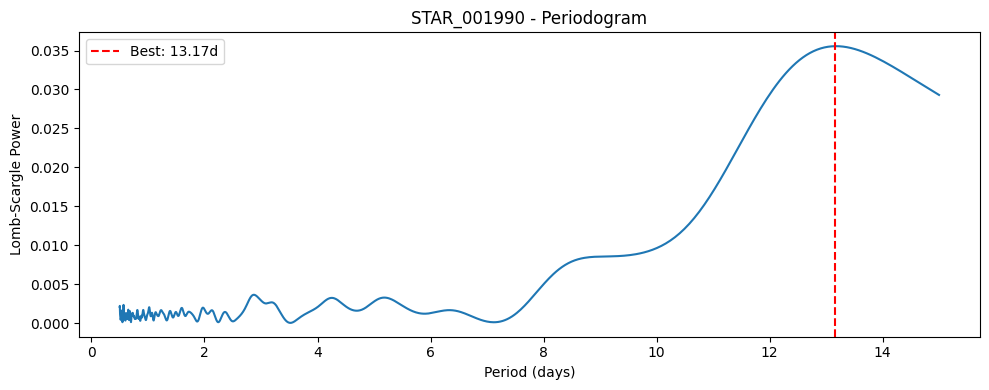

In [5]:
def lomb_scargle_analysis(times, flux, min_period=0.5, max_period=15.0, n_freqs=5000):
    """Run Lomb-Scargle periodogram (SciPy) and return results.

    Note: SciPy's lombscargle is sensitive to large time values.
    We sort and shift time to start at zero for numerical stability.
    """
    times = np.asarray(times, dtype=float)
    flux = np.asarray(flux, dtype=float)

    mask = np.isfinite(times) & np.isfinite(flux)
    times = times[mask]
    flux = flux[mask]

    if len(times) < 10:
        return {"periods": np.array([]), "power": np.array([]), "best_period": None, "best_power": None}

    sort_idx = np.argsort(times)
    times = times[sort_idx]
    flux = flux[sort_idx]

    times0 = times - times.min()

    flux_std = np.std(flux)
    if not np.isfinite(flux_std) or flux_std == 0:
        return {"periods": np.array([]), "power": np.array([]), "best_period": None, "best_power": None}

    flux_norm = (flux - np.mean(flux)) / flux_std

    # Use a uniform frequency grid (better than uniform period grid)
    freqs = np.linspace(1 / max_period, 1 / min_period, n_freqs)  # cycles/day
    angular_freqs = 2 * np.pi * freqs
    power = lombscargle(times0, flux_norm, angular_freqs, normalize=True)

    periods = 1 / freqs
    best_idx = int(np.argmax(power)) if len(power) else None

    return {
        "periods": periods,
        "power": power,
        "best_period": float(periods[best_idx]) if best_idx is not None else None,
        "best_power": float(power[best_idx]) if best_idx is not None else None,
    }


# Test on one star
test_star = "STAR_001990"
star_data = df_clean[df_clean["star_id"] == test_star]
result = lomb_scargle_analysis(star_data["btjd"].values, star_data["flux"].values)

print(f"{test_star}: Best period = {result['best_period']:.3f} days, power = {result['best_power']:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(result["periods"], result["power"])
ax.axvline(result["best_period"], color="r", ls="--", label=f"Best: {result['best_period']:.2f}d")
ax.set_xlabel("Period (days)")
ax.set_ylabel("Lomb-Scargle Power")
ax.set_title(f"{test_star} - Periodogram")
ax.legend()
plt.tight_layout()


## 5. Поиск периодических звёзд во всём каталоге

In [ ]:
# Search for periodic signals
min_points = 500
candidates = star_stats[star_stats["n_points"] >= min_points].copy()

print(f"Searching {len(candidates)} stars with >= {min_points} points...")

periodic_results = []

for i, star_id in enumerate(candidates.index):
    star_data = df_clean[df_clean["star_id"] == star_id]
    times = star_data["btjd"].values
    flux = star_data["flux"].values
    
    try:
        result = lomb_scargle_analysis(times, flux)
        periodic_results.append({
            "star_id": star_id,
            "best_period": result["best_period"],
            "ls_power": result["best_power"],
            "tic_id": candidates.loc[star_id, "tic_id"],
            "amp_robust": candidates.loc[star_id, "amp_robust"],
        })
    except:
        pass
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i+1}/{len(candidates)}")

periodic_df = pd.DataFrame(periodic_results)
print(f"\nAnalyzed {len(periodic_df)} stars")

# Top periodic candidates
periodic_df["score"] = periodic_df["ls_power"] * periodic_df["amp_robust"]
top_periodic = periodic_df.nlargest(20, "score")

print("\nTop 20 periodic candidates:")
top_periodic[["star_id", "tic_id", "best_period", "ls_power", "amp_robust"]]

Searching 2068 stars with >= 500 points...
  Processed 200/2068


## 6. Фазовое свёртывание топ-кандидатов

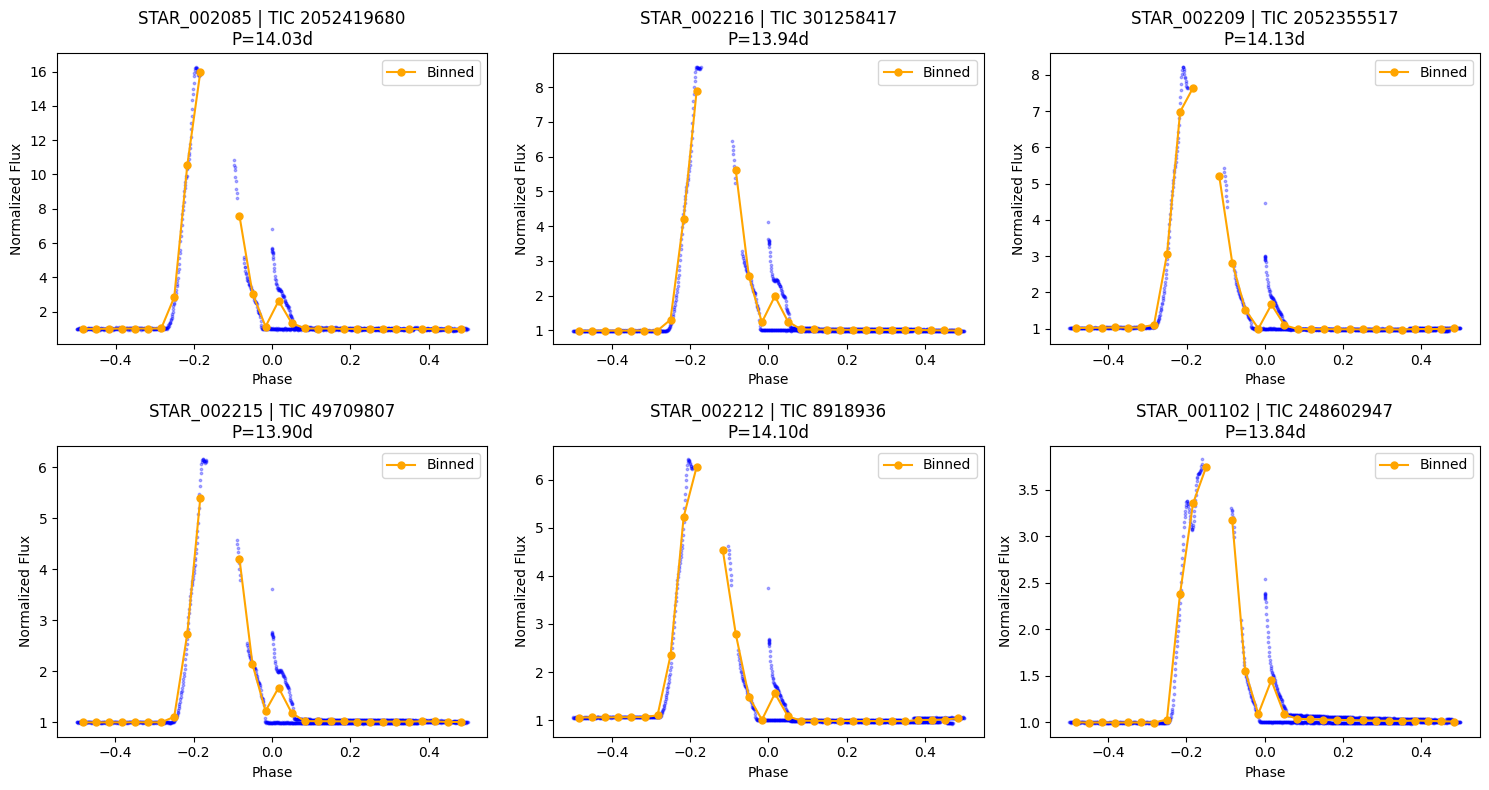

In [ ]:
def plot_phase_folded(star_id, period, df_clean, ax=None):
    """Plot phase-folded lightcurve."""
    star_data = df_clean[df_clean["star_id"] == star_id]
    times = star_data["btjd"].to_numpy(dtype=float)
    flux = star_data["flux"].to_numpy(dtype=float)

    median_flux = np.nanmedian(flux)
    if not np.isfinite(median_flux) or median_flux == 0:
        median_flux = 1.0
    flux_norm = flux / median_flux

    # Phase fold
    t0 = np.nanmin(times)
    phase = ((times - t0) / period) % 1.0
    phase = np.where(phase > 0.5, phase - 1.0, phase)

    # Sort and bin
    sort_idx = np.argsort(phase)
    phase, flux_norm = phase[sort_idx], flux_norm[sort_idx]

    n_bins = 30
    bin_edges = np.linspace(-0.5, 0.5, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    bin_vals = []
    for i in range(n_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i + 1])
        if mask.sum() > 0:
            bin_vals.append(np.nanmedian(flux_norm[mask]))
        else:
            bin_vals.append(np.nan)

    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(phase, flux_norm, s=3, alpha=0.3, c="blue")
    ax.plot(bin_centers, bin_vals, "o-", color="orange", markersize=5, label="Binned")
    ax.set_xlabel("Phase")
    ax.set_ylabel("Normalized Flux")
    ax.legend()
    return ax


# Plot top 6 candidates
n_plot = min(6, len(top_periodic))
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (_, row) in enumerate(top_periodic.head(n_plot).iterrows()):
    plot_phase_folded(row["star_id"], row["best_period"], df_clean, ax=axes[i])
    axes[i].set_title(f"{row['star_id']} | TIC {row['tic_id']} | P={row['best_period']:.2f}d")

plt.tight_layout()


In [ ]:
ts_dir = DATA_DIR / "exports" / "timeseries"
ts_paths = list(ts_dir.glob("*_timeseries.npz"))

if ts_paths:
    ts_path = pick_latest(ts_paths)
    ts = np.load(ts_path)
    print(f"Loaded timeseries: {ts_path}")
    print("X shape:", ts["X"].shape)
    print("mask shape:", ts["mask"].shape)
else:
    print("No timeseries arrays found under data/exports/timeseries")


Loaded timeseries: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\exports\timeseries\test_export_timeseries.npz
X shape: (2108, 200, 3)
mask shape: (2108, 200)


## 7. Поиск транзитов (BLS)

Транзит планеты — это **короткий периодический провал** яркости:
- Глубина: 0.1% - 1% (для горячих юпитеров до 1-2%)
- Длительность: несколько часов
- Форма: "коробка" (резкий вход и выход)

In [ ]:
def simple_bls(times, flux, periods, duration_frac=0.05):
    """Simple BLS-like scan (prototype).

    For science-grade transit search, prefer `astropy.timeseries.BoxLeastSquares`.
    """
    times = np.asarray(times, dtype=float)
    flux = np.asarray(flux, dtype=float)

    mask = np.isfinite(times) & np.isfinite(flux)
    times = times[mask]
    flux = flux[mask]

    if len(times) < 20:
        return {"periods": periods, "power": np.zeros_like(periods, dtype=float), "best_period": None, "best_power": 0.0, "best_depth": 0.0}

    # Shift time for numerical stability
    times0 = times - times.min()

    median_flux = np.median(flux)
    if not np.isfinite(median_flux) or median_flux == 0:
        return {"periods": periods, "power": np.zeros_like(periods, dtype=float), "best_period": None, "best_power": 0.0, "best_depth": 0.0}

    flux_norm = flux / median_flux

    best_power = 0.0
    best_period = float(periods[0]) if len(periods) else None
    best_depth = 0.0
    powers = []

    for period in periods:
        phase = (times0 / period) % 1.0
        n_phase_bins = 20
        phase_starts = np.linspace(0, 1 - duration_frac, n_phase_bins)

        period_best_power = 0.0

        for phase_start in phase_starts:
            in_transit = (phase >= phase_start) & (phase < phase_start + duration_frac)
            out_transit = ~in_transit

            if in_transit.sum() < 3 or out_transit.sum() < 10:
                continue

            f_in = np.mean(flux_norm[in_transit])
            f_out = np.mean(flux_norm[out_transit])
            depth = f_out - f_in

            if depth > 0:
                n_in, n_out = in_transit.sum(), out_transit.sum()
                power = depth * np.sqrt(n_in * n_out / (n_in + n_out))

                period_best_power = max(period_best_power, power)

                if power > best_power:
                    best_power = power
                    best_period = float(period)
                    best_depth = float(depth)

        powers.append(period_best_power)

    return {
        "periods": periods,
        "power": np.array(powers),
        "best_period": best_period,
        "best_power": float(best_power),
        "best_depth": float(best_depth),
    }


# Test BLS
test_star = "STAR_001990"
star_data = df_clean[df_clean["star_id"] == test_star]
periods = np.linspace(0.5, 10.0, 200)
bls_result = simple_bls(star_data["btjd"].values, star_data["flux"].values, periods)

print(f"BLS result for {test_star}:")
print(f"  Best period: {bls_result['best_period']:.3f} days")
print(f"  Transit depth: {bls_result['best_depth']*100:.3f}%")


BLS result for STAR_001990:
  Best period: 9.905 days
  Transit depth: 3.608%


## 8. Поиск кандидатов в транзиты

In [ ]:
# Filter for potential transit hosts (low amplitude)
transit_candidates = star_stats[
    (star_stats["n_points"] >= 500) & 
    (star_stats["amp_robust"] < 0.05) &
    (star_stats["amp_robust"] > 0.001)
].copy()

print(f"Potential transit hosts: {len(transit_candidates)} stars")

# Run BLS on sample
transit_results = []
periods = np.linspace(0.5, 10.0, 150)
n_search = min(100, len(transit_candidates))
sample_stars = transit_candidates.sample(n_search, random_state=42).index

print(f"Running BLS on {n_search} stars...")

for i, star_id in enumerate(sample_stars):
    star_data = df_clean[df_clean["star_id"] == star_id]
    if len(star_data) < 100:
        continue
    
    try:
        result = simple_bls(star_data["btjd"].values, star_data["flux"].values, periods)
        transit_results.append({
            "star_id": star_id,
            "period": result["best_period"],
            "depth_pct": result["best_depth"] * 100,
            "bls_power": result["best_power"],
            "tic_id": transit_candidates.loc[star_id, "tic_id"],
        })
    except:
        pass
    
    if (i + 1) % 25 == 0:
        print(f"  Processed {i+1}/{n_search}")

transit_df = pd.DataFrame(transit_results)
transit_df = transit_df[transit_df["depth_pct"] > 0.1]
top_transits = transit_df.nlargest(10, "bls_power")

print(f"\nTop transit candidates:")
top_transits

Potential transit hosts: 1507 stars
Running BLS on 100 stars...
  Processed 25/100
  Processed 50/100
  Processed 75/100
  Processed 100/100

Top transit candidates:


,star_id,period,depth_pct,bls_power,tic_id
46,STAR_001552,7.768456,4.625518,0.314699,2052392634
32,STAR_001808,8.724832,3.661375,0.277292,9664544
36,STAR_000499,8.852349,3.119265,0.243608,37665058
2,STAR_000600,7.895973,3.499542,0.228353,300964959
79,STAR_000408,6.238255,2.633434,0.201019,610514599
18,STAR_000721,6.365772,2.389257,0.185204,37694491
57,STAR_001338,6.302013,1.865653,0.168367,9726426
65,STAR_000997,6.365772,2.048061,0.158756,37664274
71,STAR_000858,6.365772,1.951794,0.151294,398668627
21,STAR_001669,7.130872,2.073395,0.150630,250109114


## 9. Визуализация кандидатов в транзиты

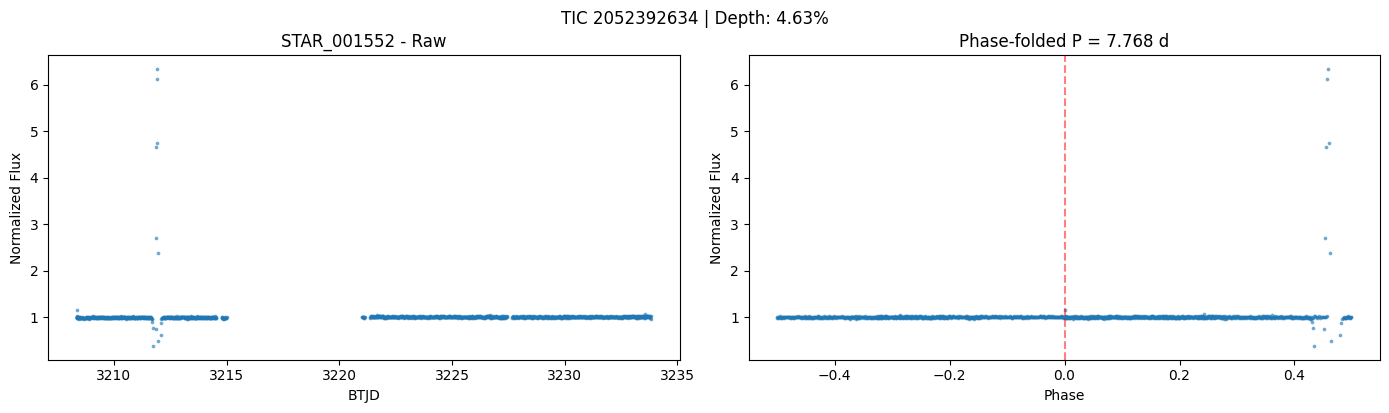

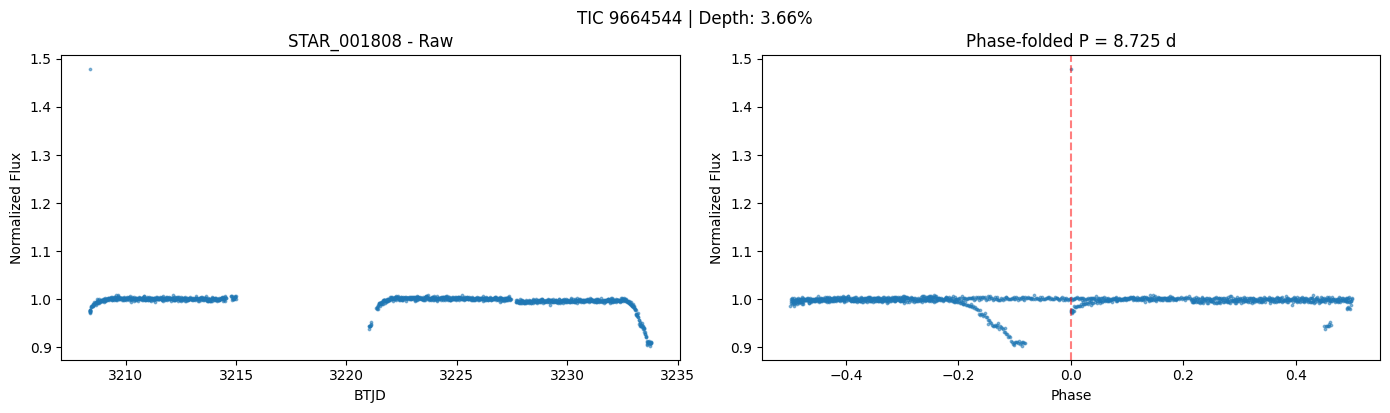

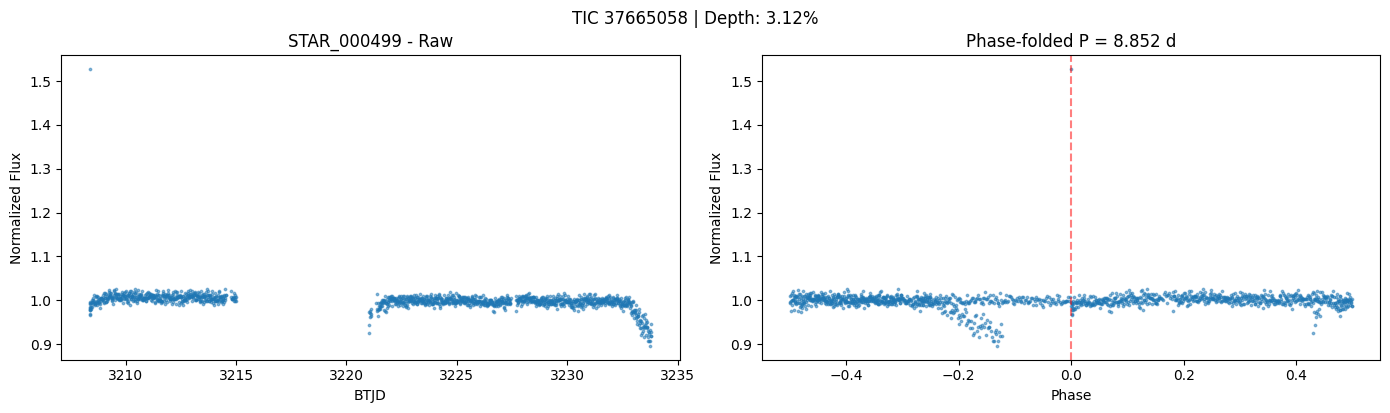

In [ ]:
def plot_transit_candidate(star_id, period, df_clean):
    """Plot transit candidate."""
    star_data = df_clean[df_clean["star_id"] == star_id]
    times = star_data["btjd"].values
    flux = star_data["flux"].values
    flux_norm = flux / np.median(flux)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Raw
    axes[0].scatter(times, flux_norm, s=3, alpha=0.5)
    axes[0].set_xlabel("BTJD")
    axes[0].set_ylabel("Normalized Flux")
    axes[0].set_title(f"{star_id} - Raw")
    
    # Phase-folded
    phase = ((times - times[0]) / period) % 1.0
    phase = np.where(phase > 0.5, phase - 1.0, phase)
    
    axes[1].scatter(phase, flux_norm, s=3, alpha=0.5)
    axes[1].set_xlabel("Phase")
    axes[1].set_ylabel("Normalized Flux")
    axes[1].set_title(f"Phase-folded P = {period:.3f} d")
    axes[1].axvline(0, color="red", ls="--", alpha=0.5)
    
    plt.tight_layout()
    return fig

# Plot top 3
if len(top_transits) > 0:
    for _, row in top_transits.head(3).iterrows():
        fig = plot_transit_candidate(row["star_id"], row["period"], df_clean)
        plt.suptitle(f"TIC {row['tic_id']} | Depth: {row['depth_pct']:.2f}%", y=1.02)
        plt.show()
else:
    print("No strong transit candidates found")

## 10. Поиск аномалий (вспышки, тренды)

Ищем звёзды с необычным поведением:
- Одиночные вспышки (flares)
- Резкие изменения яркости

In [ ]:
def find_anomalies(star_id, df_clean, sigma_threshold=5):
    """Find anomalous points using a robust (MAD) z-score."""
    star_data = df_clean[df_clean["star_id"] == star_id]
    flux = star_data["flux"].to_numpy(dtype=float)
    flux = flux[np.isfinite(flux)]

    if len(flux) < 10:
        return {"n_anomalies": 0, "max_deviation": np.nan}

    median = float(np.median(flux))
    mad = float(median_abs_deviation(flux))

    sigma = mad * 1.4826
    if not np.isfinite(sigma) or sigma == 0:
        return {"n_anomalies": 0, "max_deviation": 0.0}

    z_score = np.abs(flux - median) / sigma
    anomaly_mask = z_score > sigma_threshold

    return {
        "n_anomalies": int(anomaly_mask.sum()),
        "max_deviation": float(np.max(z_score)),
    }


# Find anomalous stars
anomaly_results = []

for star_id in star_stats.index:
    star_data = df_clean[df_clean["star_id"] == star_id]
    if len(star_data) < 100:
        continue

    result = find_anomalies(star_id, df_clean)
    result["star_id"] = star_id
    result["tic_id"] = star_stats.loc[star_id, "tic_id"] if "tic_id" in star_stats.columns else None
    anomaly_results.append(result)

anomaly_df = pd.DataFrame(anomaly_results)
top_anomalies = anomaly_df.nlargest(15, "n_anomalies")

print("Stars with most anomalous points:")
top_anomalies


Stars with most anomalous points:


,n_anomalies,max_deviation,star_id,tic_id
1196,473,183.509070,STAR_001268,610495564
191,470,94.347122,STAR_000209,610555096
1229,462,139.248504,STAR_001302,9791889
1097,453,140.246654,STAR_001163,176297057
292,416,221.145974,STAR_000314,300907523
70,269,83.993602,STAR_000081,300966134
1035,262,24.798740,STAR_001101,248604546
1036,233,198.799041,STAR_001102,248602947
854,198,161.505621,STAR_000905,2052474950
1537,198,229.724685,STAR_001639,2052708621


## 11. Итоги

### Что мы нашли:

1. **Периодические переменные** — звёзды с регулярными колебаниями
2. **Кандидаты в транзиты** — требуют проверки на ExoFOP
3. **Аномалии** — звёзды с выбросами

### Проверка кандидатов:

- ExoFOP-TESS: `https://exofop.ipac.caltech.edu/tess/target.php?id={TIC_ID}`
- NASA Exoplanet Archive: `https://exoplanetarchive.ipac.caltech.edu/`

### Следующие шаги:

- Проверить кандидатов в базе известных экзопланет
- Запросить данные с бо́льшим временным охватом
- Применить машинное обучение для классификации